Импортируем библиотеки

In [43]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px

from plotly.offline import init_notebook_mode, iplot

Считаем данные

In [95]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')

/tmp/ipykernel_32/409789061.py:1: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



Соединим данные в единый датафрейм

In [217]:
merged_data = ratings.merge(books, on='ISBN').merge(users, on='User-ID')
merged_data['Country'] = merged_data.Location.str.split(', ').apply(lambda x: x[2] if len(x) == 3 else np.nan)
merged_data.head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age,Country
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN,usa
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"cincinnati, ohio, usa",23.0,usa
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,"cincinnati, ohio, usa",23.0,usa


Для дальнейшего анализа оставим только рейтинги больше нуля

In [218]:
merged_data_without_zeros = merged_data[merged_data['Book-Rating'] > 0]

In [219]:
def plot_categorical_stats(data, categorical_column, n_samples=20):
#     top_categories_counts = data[categorical_column].value_counts().head(7)
    if n_samples == -1:
        random_categories_counts = data[categorical_column].value_counts()
    else:
        random_categories_counts = data[categorical_column].value_counts().sample(n_samples)
    categories = random_categories_counts.index.tolist()
    
    category_stats = data[data[categorical_column].isin(categories)].groupby(categorical_column, as_index=False)['Book-Rating'].agg(['mean', 'median', 'max', 'min'])
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=categories,
        y=category_stats['mean'],
        name='Mean',
        marker_color='rgb(55, 83, 109)'
    ))
    fig.add_trace(go.Bar(
        x=categories,
        y=category_stats['median'],
        name='Median',
        marker_color='rgb(54, 71, 97)'
    ))
    fig.add_trace(go.Bar(
        x=categories,
        y=category_stats['min'],
        name='Min',
        marker_color='rgb(122, 165, 216)'
    ))
    fig.add_trace(go.Bar(
        x=categories,
        y=category_stats['max'],
        name='Max',
        marker_color='rgb(101, 136, 178)'
    ))

    fig.update_layout(
        title=f'Statistics of Book-Rating for Random 20 {categorical_column}',
        xaxis_tickfont_size=14,
        yaxis=dict(
            title='Rating Value',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1,
        height=600
    )
    return fig

Посмотрим на распределения рейтингов в зависимости от категориальных переменных

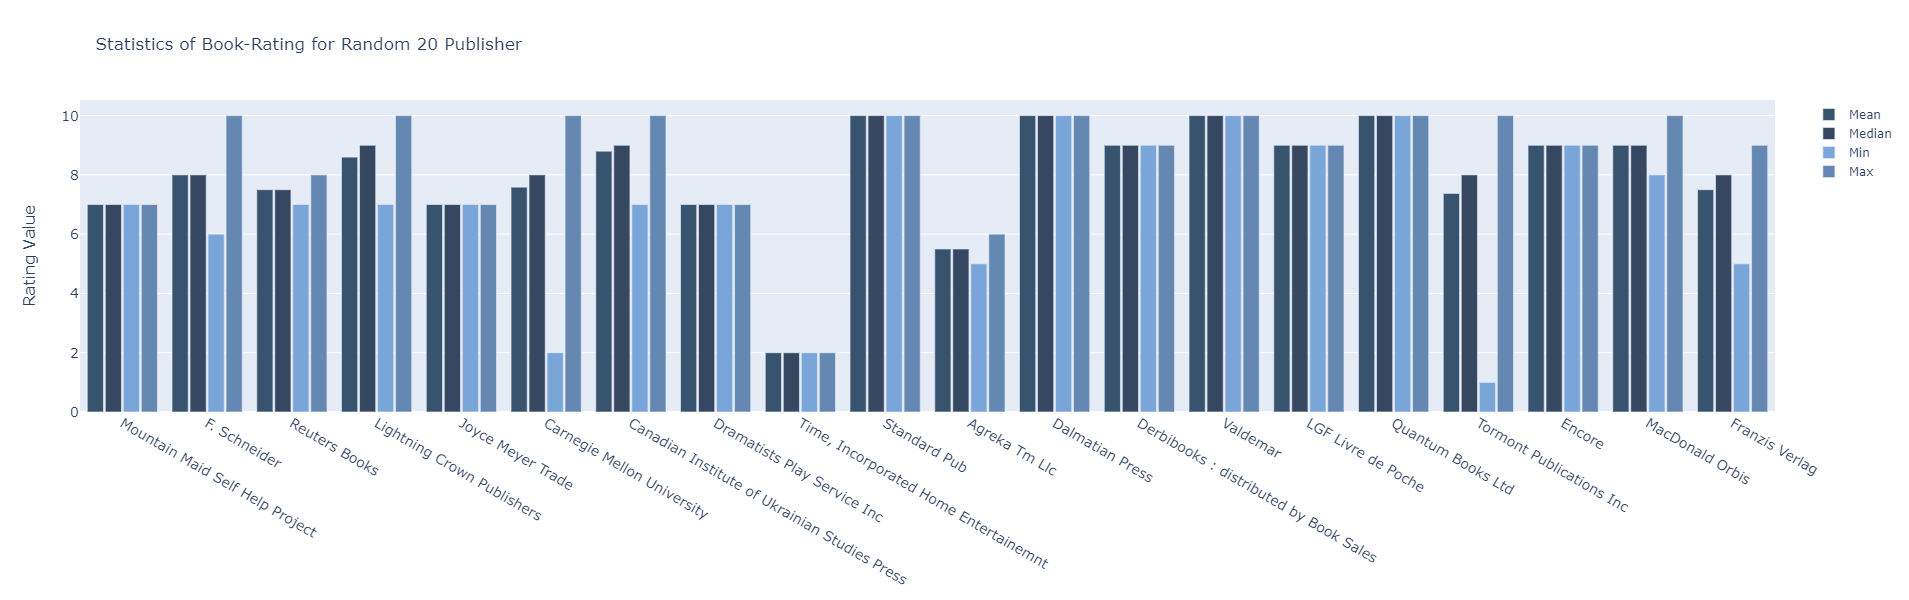

In [220]:
iplot(plot_categorical_stats(merged_data_without_zeros, 'Publisher'))

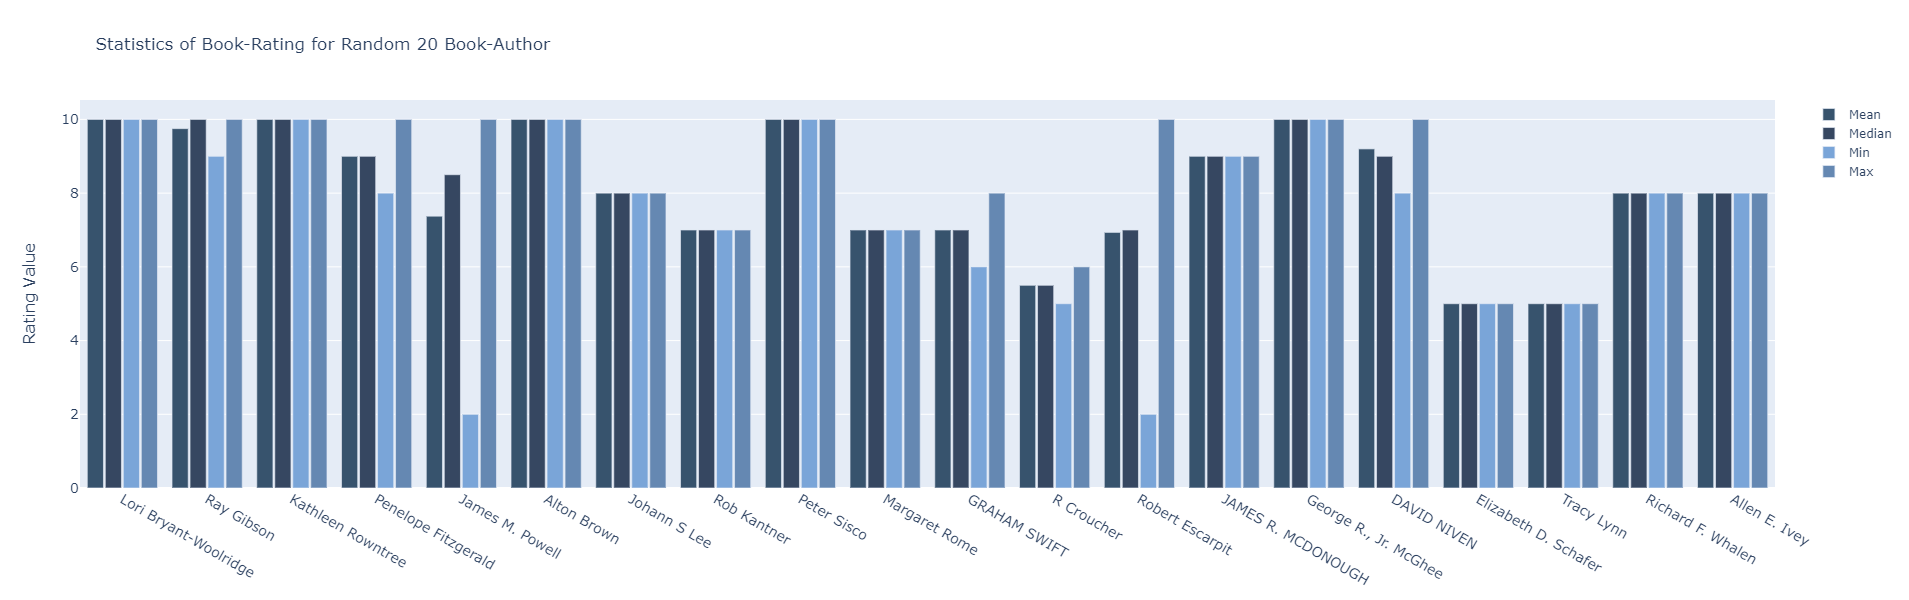

In [221]:
iplot(plot_categorical_stats(merged_data_without_zeros, 'Book-Author'))

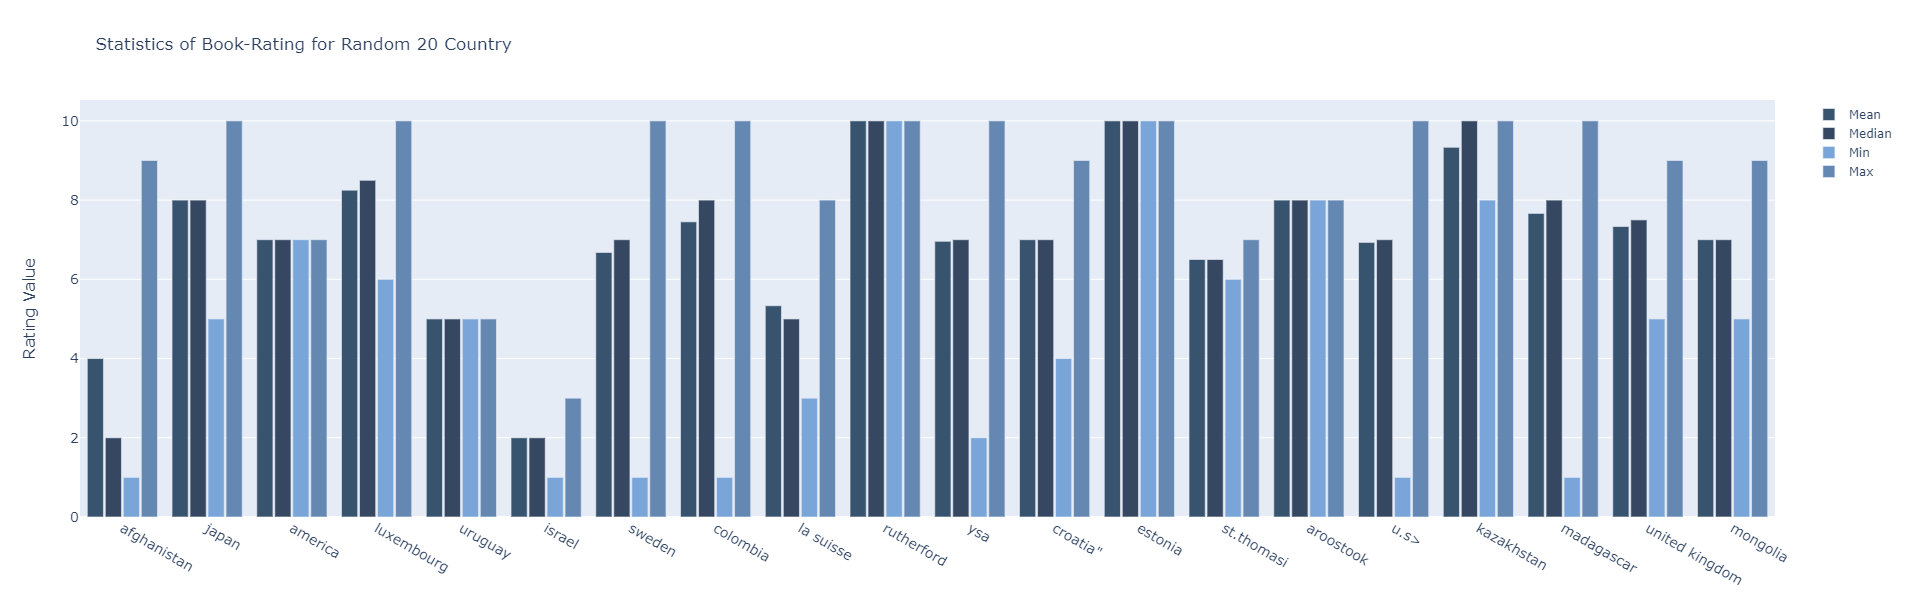

In [222]:
iplot(plot_categorical_stats(merged_data_without_zeros, 'Country'))

In [230]:
def plot_time_based_stats(data, time_column='Year-Of-Publication'):
    time_stats = data.groupby(time_column)['Book-Rating'].agg(['mean', 'median', 'max', 'min']).sort_values(time_column)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=time_stats.index,
        y=time_stats['mean'],
        mode='lines+markers',
        name='Mean',
        marker_color='rgb(55, 83, 109)'
    ))
    fig.add_trace(go.Scatter(
        x=time_stats.index,
        y=time_stats['median'],
        mode='lines+markers',
        name='Median',
        marker_color='rgb(54, 71, 97)'
    ))
    fig.add_trace(go.Scatter(
        x=time_stats.index,
        y=time_stats['min'],
        mode='lines+markers',
        name='Min',
        marker_color='rgb(122, 165, 216)'
    ))
    fig.add_trace(go.Scatter(
        x=time_stats.index,
        y=time_stats['max'],
        mode='lines+markers',
        name='Max',
        marker_color='rgb(101, 136, 178)'
    ))


    fig.update_layout(
        title=f'Statistics of Book-Rating Over Time ({time_column})',
        xaxis_tickfont_size=14,
        xaxis_title=time_column,
        yaxis=dict(
            title='Rating Value',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        height=600
    )
    return fig

In [231]:
def convert_to_int(x):
    try:
        return int(x)
    except:
        return np.nan
merged_data_without_zeros['Year-Of-Publication'] = merged_data_without_zeros['Year-Of-Publication'].apply(convert_to_int)

In [232]:
merged_data_ts = merged_data_without_zeros.dropna(subset=['Year-Of-Publication'])
merged_data_ts['Year-Of-Publication'] = pd.to_datetime(merged_data_ts['Year-Of-Publication'], format='%Y', errors='coerce')

Посмотрим на статистики рейтингов в динамике:

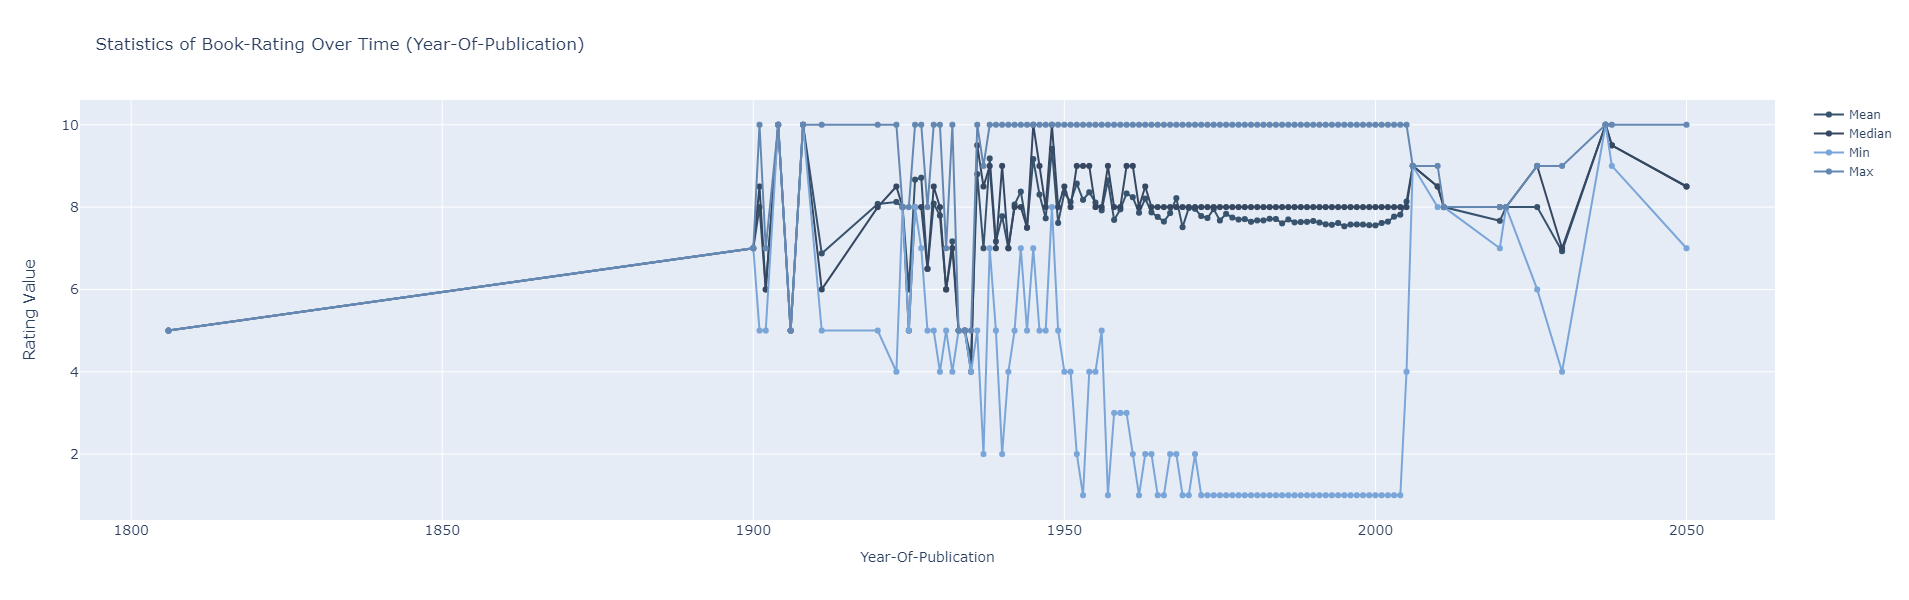

In [233]:
iplot(plot_time_based_stats(merged_data_ts))

Посмотрим корреляции:

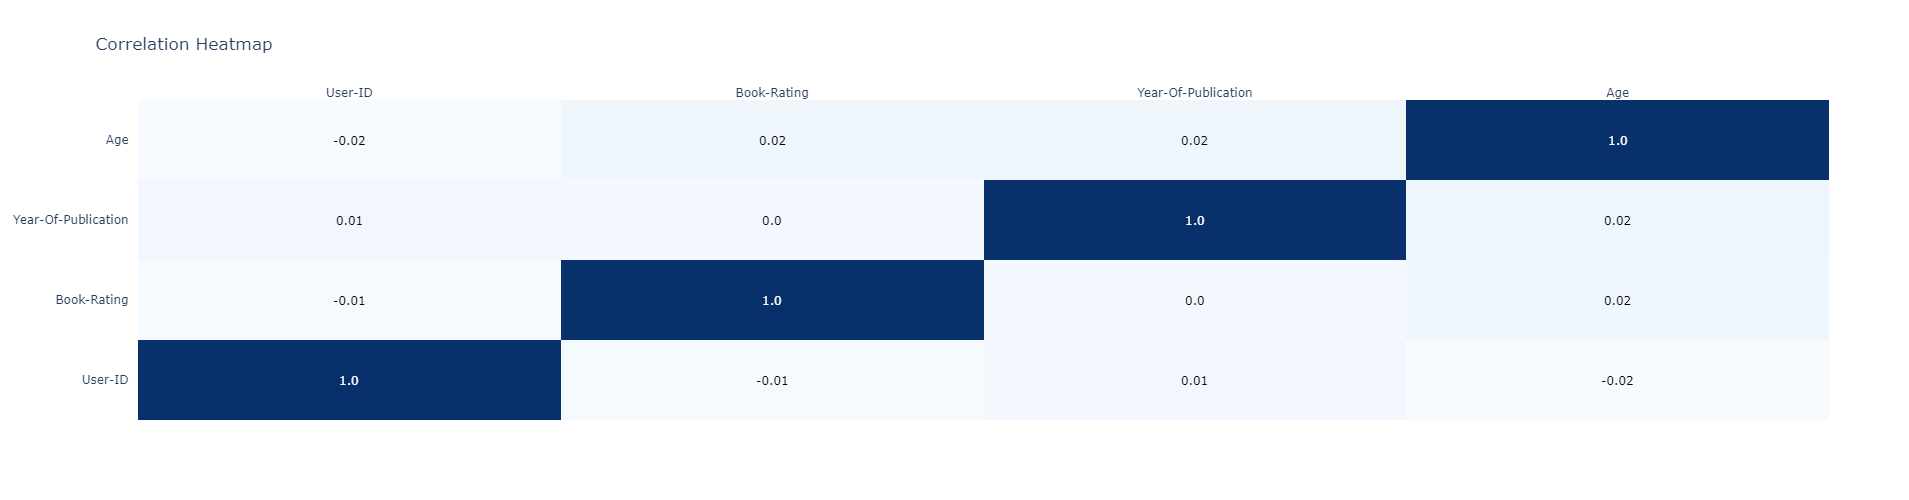

In [172]:
import plotly.figure_factory as ff

numeric_columns = merged_data_without_zeros.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

heatmap = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=list(correlation_matrix.columns),
    y=list(correlation_matrix.index),
    annotation_text=correlation_matrix.round(2).values,
    colorscale='Viridis'
)
heatmap.update_layout(title='Correlation Heatmap', height=500, width=600)
heatmap.show()

Выводы:
* Линейных корреляций в датасете нет
* Рейтинги довольно сильно меняются в зависимости от издателя, года, страны и автора
* Есть ошибки в данных